In [1]:
library(dyno)
library(scran)
library(igraph)
library(scater)
library(dyngen)
library(tidyverse)

options(repr.plot.width=15, repr.plot.height=15)

Loading required package: dynfeature

Loading required package: dynguidelines

Loading required package: dynmethods

Loading required package: dynplot

Loading required package: dynwrap

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowColla

# Simulating Cell Population without Trajectories

## Creating Complex End Point Cell Populations

### Utility Functions

In [4]:
############################# Wrapper Function to Generate Cell Pop and Branch Module Network #############################

backbone_single_cell_population = function(num_of_pops=1, edge_prob=0.2, min_mod=10, max_mod=20) {
    cellpop_backbone = backbone_multiple_cell_populations(num_of_pops, edge_prob, min_mod, max_mod)
    return (cellpop_backbone)
}


backbone_multiple_cell_populations = function(num_of_pops=sample(2:5, 1), edge_prob=0.2, min_mod=10, max_mod=20) {
    # for the user defined number of cell populations generate both branch module and individual cell pop module networks.
    n_cellpops = 1:num_of_pops
    cellpop_names = paste0('CellPop', n_cellpops, '_')
    
    # generating module networks of branches and cell populations
    cellpop_meta = create_cellpops(n_cellpops, cellpop_names, edge_prob, min_mod, max_mod)
    branch_meta = create_branches(n_cellpops, cellpop_names, cellpop_meta$module_info)
    
    # adding a burn phase and connecting it the branch modules
    start_branch = bblego_start('B', type = "simple", num_modules = 2)
    multiple_cellpop_backbone = bblego(start_branch, branch_meta, cellpop_meta)
    
    return (multiple_cellpop_backbone)
}

############################# Utility Function for Generating Cell Pop End State #############################

create_cellpops = function(n_cellpops, cellpop_names, edge_prob=0.2, min_mod=10, max_mod=20){
    # For every cell population specified generate a random module network unique to that cell pop.
    cellpop_meta = c()
    modules_range = min_mod:max_mod
    
    for (i in n_cellpops) {
        # create cell population name
        cellpop_name = cellpop_names[i]

        # select number of modules in cell pop and generate graph
        num_modules = sample(modules_range, 1)
        generated_net = erdos.renyi.game(num_modules, edge_prob, directed=TRUE, loops=TRUE)

        # create cell population metadata
        module_info = create_module_info(generated_net, cellpop_name)
        expression_patterns = create_expression_pattern(module_info, cellpop_name)
        module_network = create_module_network(generated_net, module_info, cellpop_name)

        # adding current cell pop meta to cellpop_meta vector
        meta = list(module_info=module_info, module_network=module_network, expression_patterns=expression_patterns)
        cellpop_meta = c(cellpop_meta, list(meta))
    }
    
    cellpop_meta = list(module_info = map_df(cellpop_meta, "module_info"), 
                        module_network = map_df(cellpop_meta, "module_network"), 
                        expression_patterns = map_df(cellpop_meta, "expression_patterns"))
    
    return (cellpop_meta)
}

create_module_info = function(cellpop_network, cellpop_name) {
    # generate the module info 
    module_info = list()
    module_info$module_id = as.numeric(V(cellpop_network))
    module_info$in_degree = degree(cellpop_network, mode='in')
    module_info$out_degree = degree(cellpop_network, mode='out')
    
    module_info = module_info %>% 
                    as_tibble %>%
                    mutate(module_id=paste0(cellpop_name, module_id),
                           basal = ifelse(in_degree == 0, 1, 0),
                           burn = FALSE,
                           independence = 1)
    
    return (module_info)
}

create_expression_pattern = function(module_info, cellpop_name) {
    # creating an expression patterns
    sphase = paste0("s", cellpop_name)
    ephase = paste0("e", cellpop_name)
    modules_in_state = paste("+", module_info$module_id, sep='', collapse=',')

    expression_patterns = tribble(
      ~from, ~to, ~module_progression, ~start, ~burn, ~time,
      sphase, ephase, modules_in_state, FALSE, FALSE, 120,
    )
    
    return (expression_patterns)
}

create_module_network = function(cellpop_net, module_info, cellpop_name) {
    # creating the module networks metadata
    module_network = igraph::as_edgelist(cellpop_net) %>%
                                as.data.frame %>%
                                rename(from = V1, to = V2) %>%
                                mutate(to = paste0(cellpop_name, to),
                                       from = paste0(cellpop_name, from), 
                                       effect = 1L, 
                                       strength = sample(1:10, gsize(cellpop_net), replace=TRUE),
                                       hill = 2) %>%
                                do(randomize_module_effect(.data, module_info)) %>%
                                as_tibble
    
    return (module_network)
}

randomize_module_effect = function(module_expr, modules_info) {
    # randomly assign whether in degree positively or negatively regulate
    # this module. Unless there is 1 or 0 in degree. In this case level the effect
    # as positive regulation.
    
    nodes_in_degree = modules_info$in_degree
    names(nodes_in_degree) = modules_info$module_id
    
    for (i in 1:nrow(module_expr)) {
        module = module_expr[i, ]$to
        in_degree = nodes_in_degree[[module]]
        
        if (in_degree == 1){
            next()
        }

        nodes_in_degree[[module]] = in_degree - 1 
        module_expr[i, ]$effect = sample(c(1L, -1L), size=1)   
    }
    
    return (module_expr)
}

############################# Utility Function for Generating Branching Modules #############################

create_branches = function(n_cellpops, cellpop_names, module_info) {
    network = data.frame()
    info = data.frame(module_id=c("B1"), basal=c(0), burn=c(TRUE), independence=c(1))
    expr_pat = data.frame(from=c("sB","sBmid"),to=c("sBmid","sBend"),
                          module_progression=c('+B1', paste0('+B1,',paste('+B', n_cellpops + 1, sep='', collapse= ','))),
                          start=c(FALSE),burn=c(TRUE),time=c(40))

    for (i in n_cellpops) {
        cellpop_name = cellpop_names[i]
        branch = paste0('B', i+1)
        start = paste0('s', cellpop_name)
        cellpop_module = module_info %>% filter(grepl(cellpop_name, module_id))  %>% pull(module_id)
        
        info = create_branches_info(info, branch)
        expr_pat = create_branches_expr_pat(expr_pat, branch, start)
        network = create_branches_network(network, branch, n_cellpops, cellpop_module)
    }

    branch_meta = list(module_info = info, module_network = network, expression_patterns = expr_pat)
    return (branch_meta)
}

find_largest_out_degree = function(cellpop_name, module_info) {
    cell_info = module_info %>% filter(grepl(cellpop_name, module_id))  %>% pull(module_id)
    
    cell_out_degree = max(cell_info$out_degree)
    
    max_modules = cell_info %>% filter(out_degree == cell_out_degree) %>% select(module_id)
    
    if (nrow(max_modules) == 1) {
        cellpop_module = max_modules$module_id
    } else {
        cellpop_module = max_modules$module_id[1]
    }
    
    return (cellpop_module)
}

create_branches_info = function(info, branch) {
    info_row = data.frame(module_id=c(branch), basal=c(0), burn=c(TRUE), independence=c(1))
    info = rbind(info, info_row)
    
    return (info)
}

create_branches_expr_pat = function(expr_pat, branch, start) {
    
    expr_pat_row = data.frame(from=c("sBend"), to=c(start), 
                              module_progression=c(paste0('+',branch)),
                              start=c(FALSE), burn=c(TRUE), time=c(40))
    
    expr_pat = rbind(expr_pat, expr_pat_row)
    
    return (expr_pat)
}

create_branches_network = function(network, branch, n_cellpops, cellpop_module) {
    # adding branch metadata to module network
    burn_row = data.frame(from=c("B1"), to=c(branch), effect=c(1L), strength=c(1), hill=c(2))
    cellpop_row = data.frame(from=c(branch), to=c(cellpop_module), effect=c(1L), strength=c(1), hill=c(2))
    
    network = rbind(network, burn_row)
    network = rbind(network, cellpop_row)
    
    # adding inhibitory relations between different branches in the module network
    for (i in n_cellpops) {
        other_branch = paste0('B', i + 1)
        
        # we don't want a given branch to inhibit itself.
        if (branch == other_branch) {
            next()
        }
        
        network_row = data.frame(from=c(branch),to=c(other_branch),effect=c(-1L),strength=c(1),hill=c(2))
        network = rbind(network, network_row)
    }
    
    return (network)
}

## Testing my Cell Population Module

In [5]:
num_cells = 5000

cellpops_backbone = backbone_multiple_cell_populations()

config = initialise_model(
    backbone = cellpops_backbone,
    num_cells = num_cells,
    num_tf = 200,
    num_targets = 500,
    num_hks = 500,
    gold_standard_params = gold_standard_default(
      census_interval = 1,
      tau = 100 / 3600
    ),
    simulation_params = simulation_default(
      census_interval = 10,
      ssa_algorithm = ssa_etl(tau = 300 / 3600),
      experiment_params = simulation_type_wild_type(
        num_simulations = num_cells / 10
       )
    )
  )

config$num_cores = 5

In [6]:
model = config %>%
          generate_tf_network() %>%
          generate_feature_network()

Generating TF network
Sampling feature network from real network


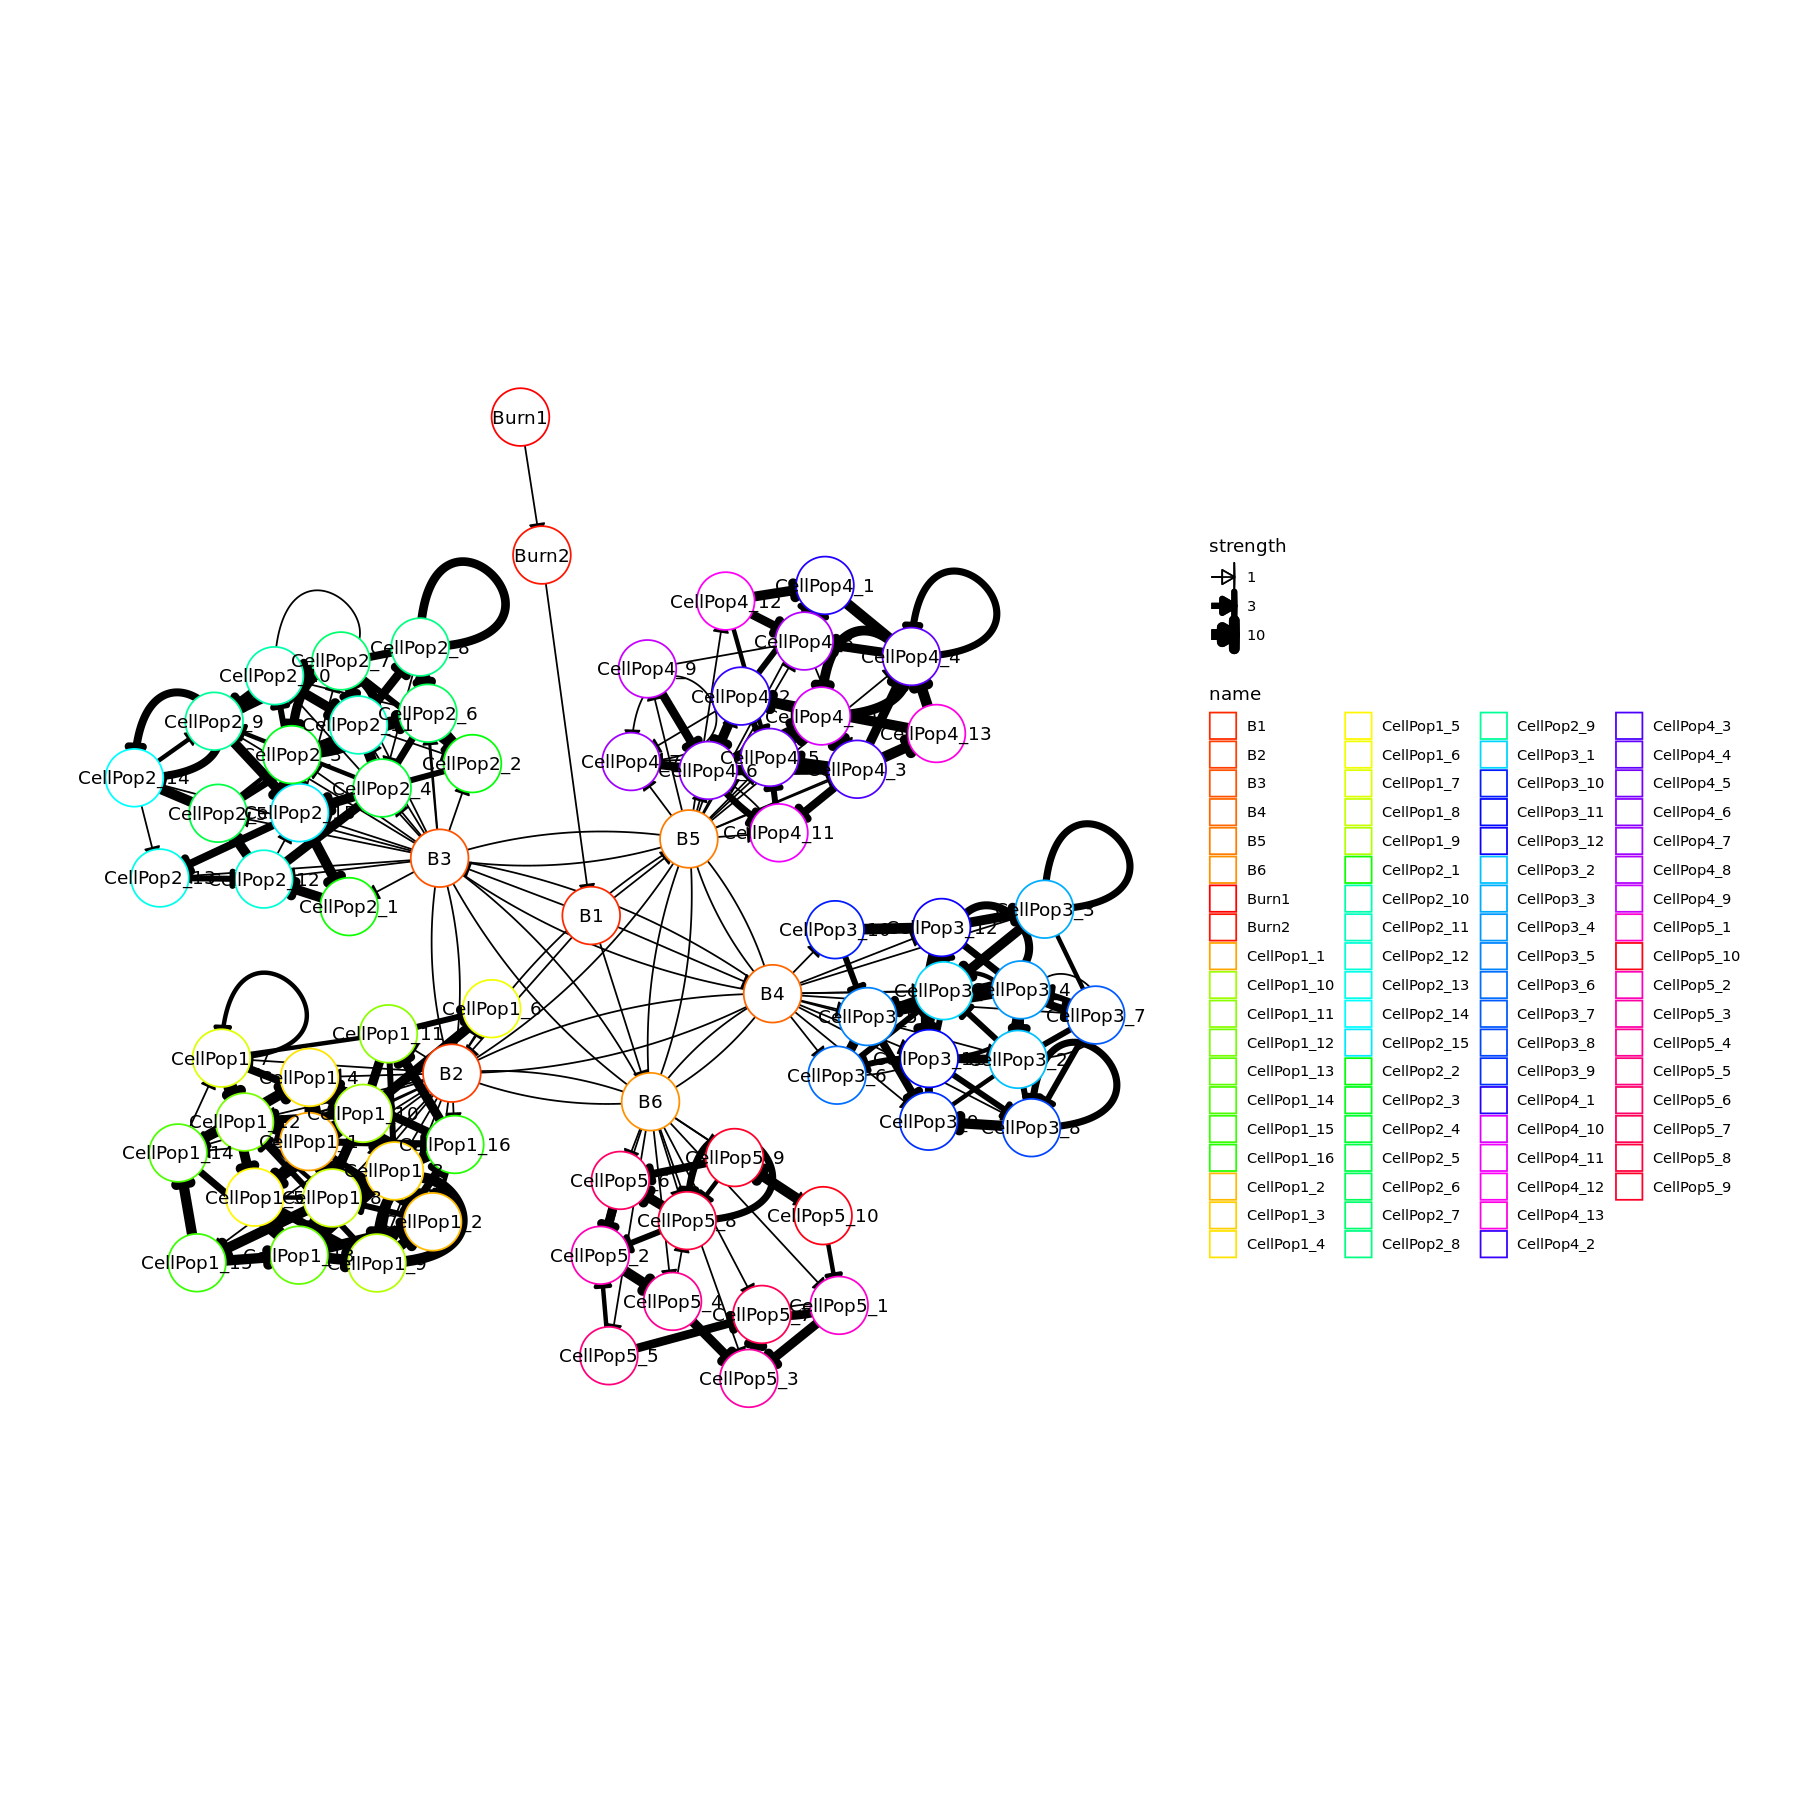

In [7]:
plot_backbone_modulenet(config)

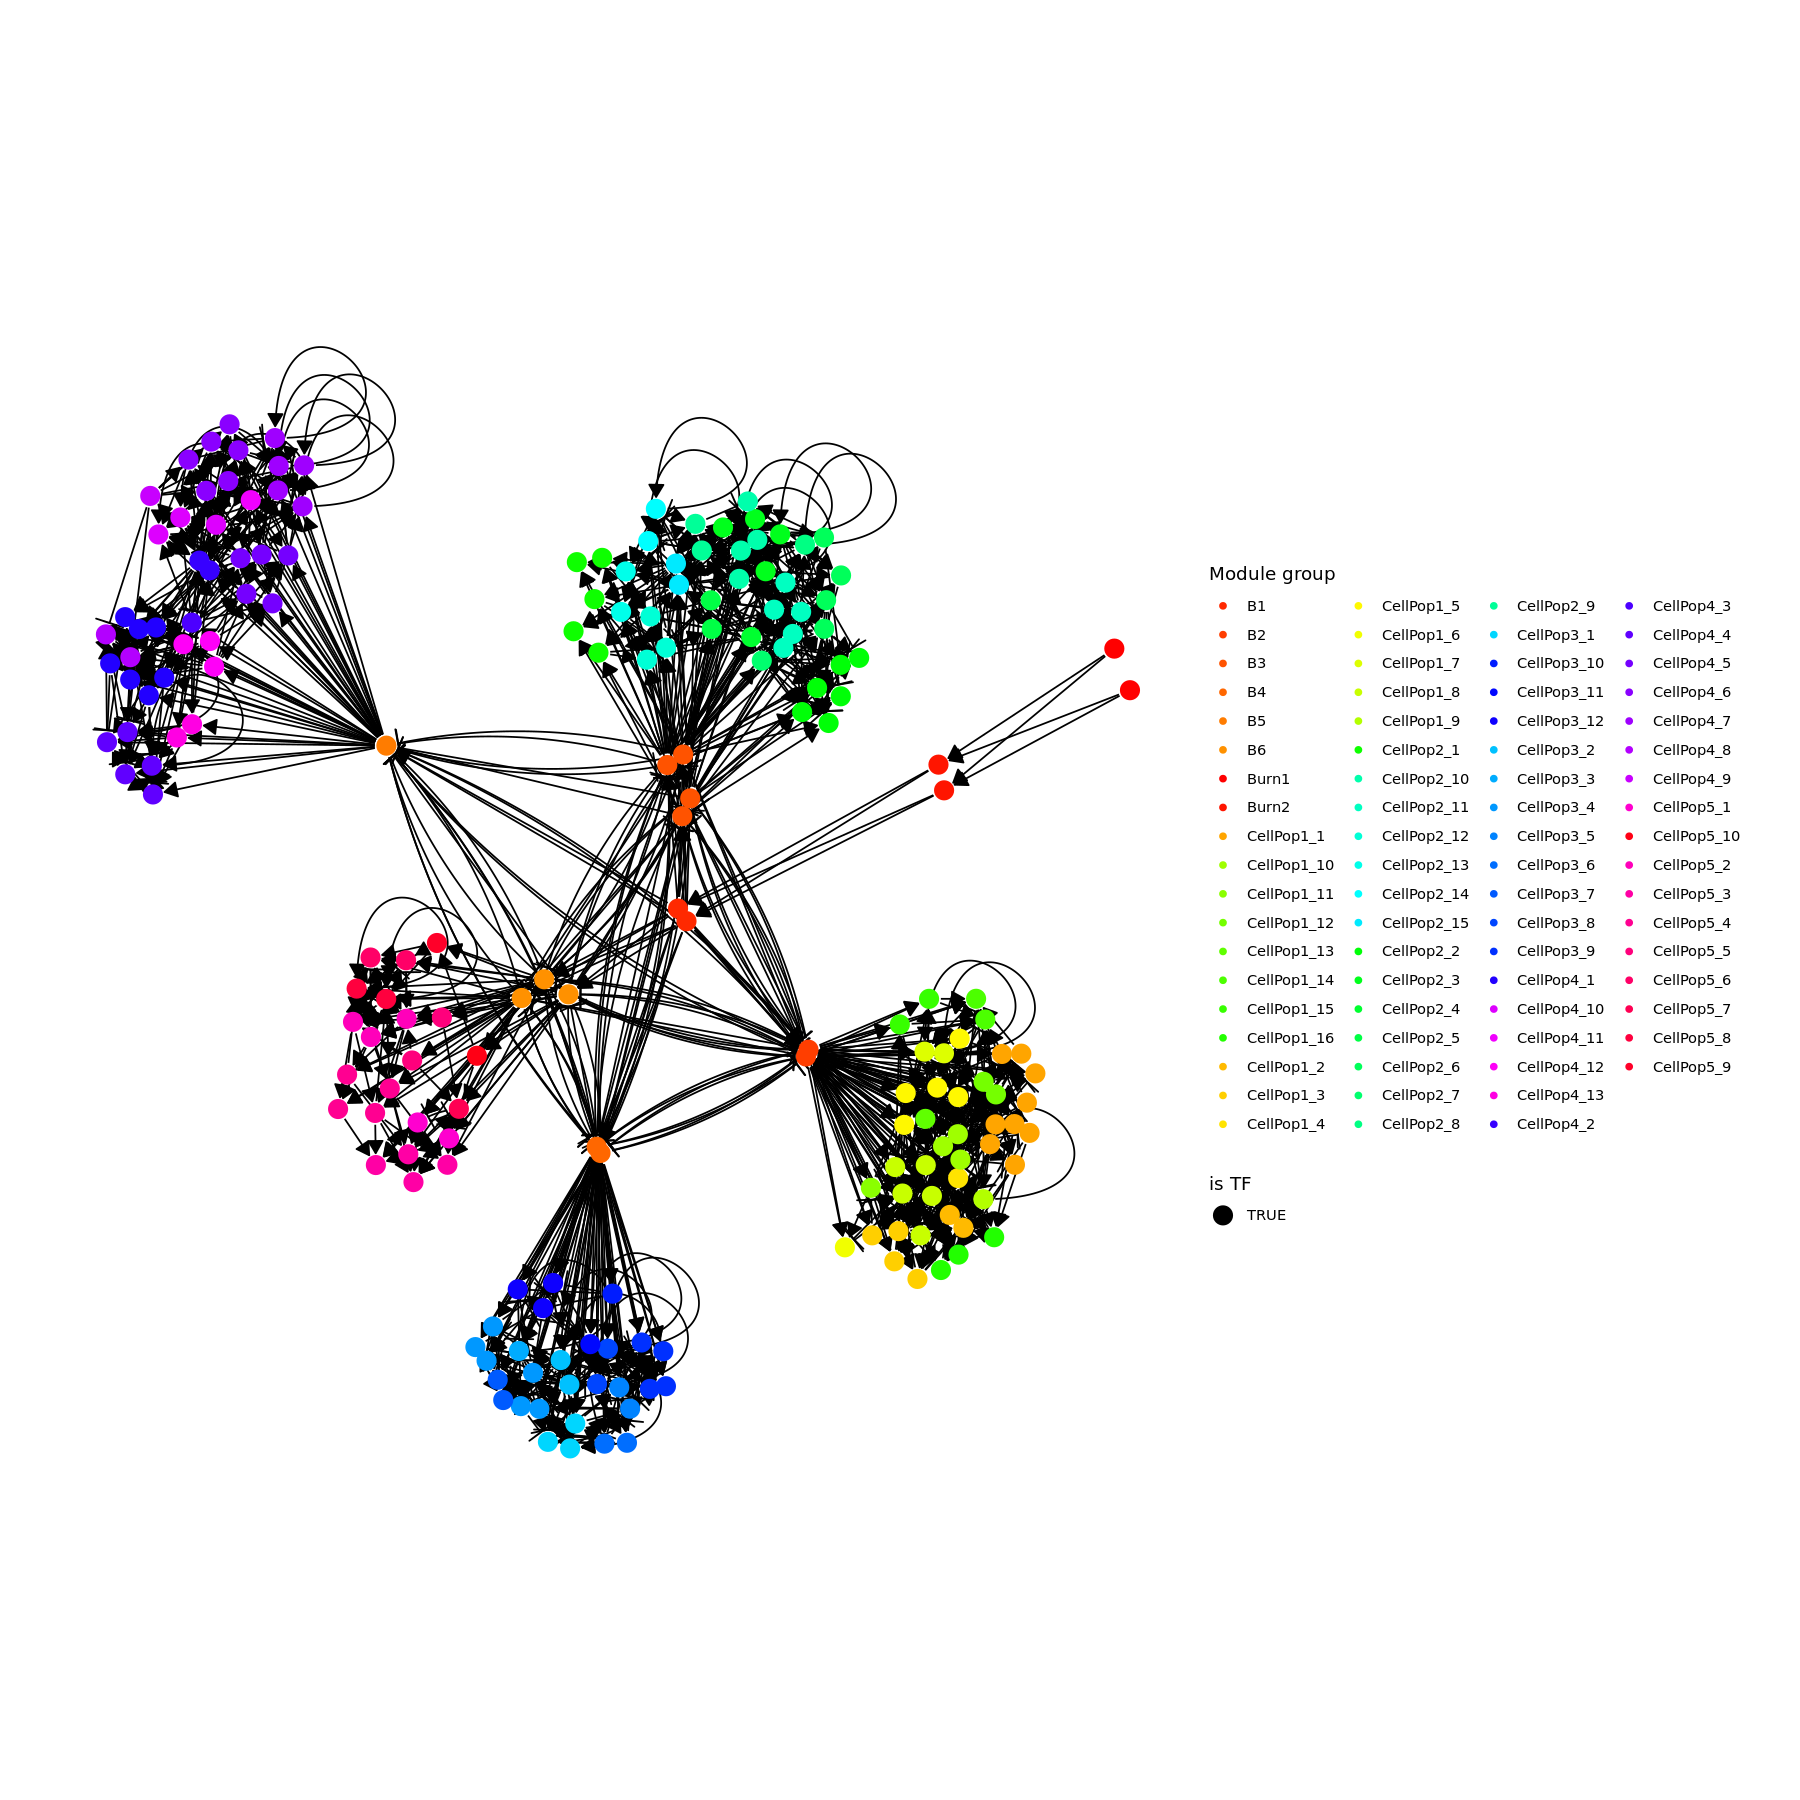

In [8]:
plot_feature_network(model, show_targets = FALSE)

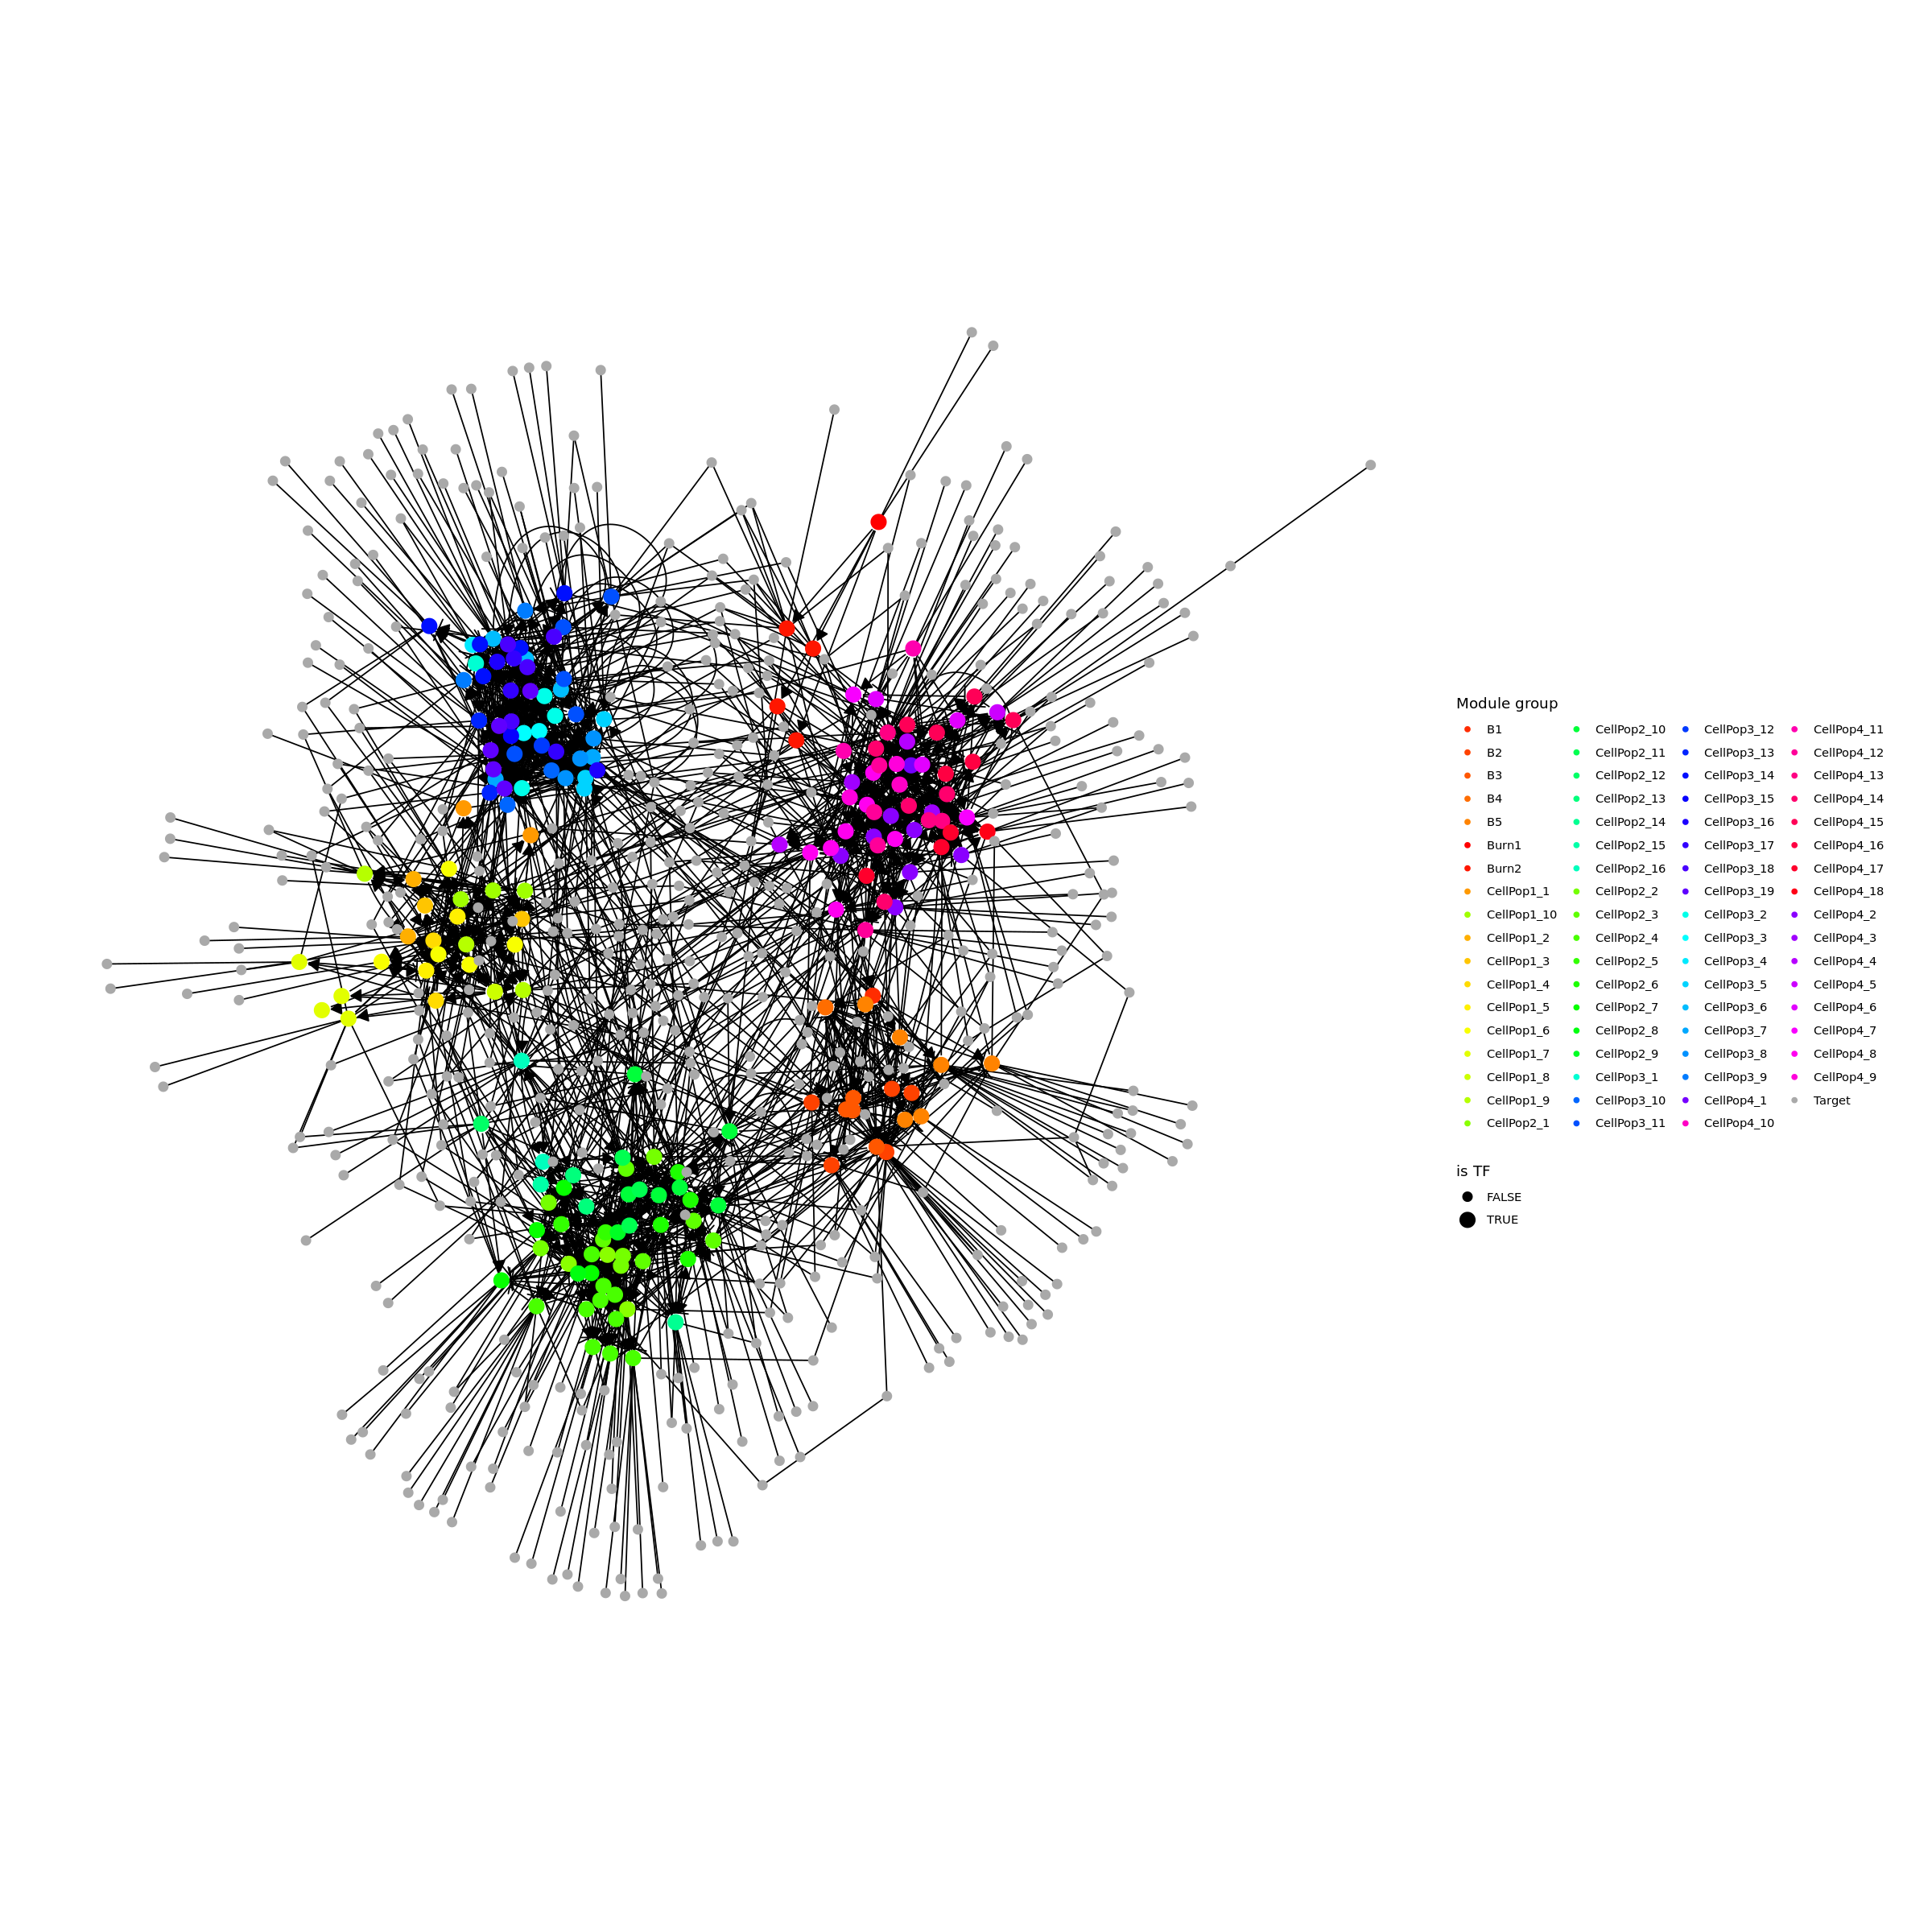

In [383]:
plot_feature_network(model)

In [384]:
model = model %>% 
          generate_kinetics() %>%
          generate_gold_standard() %>%
          generate_cells() %>% 
          generate_experiment()

Generating kinetics for 1200 features
Generating formulae
Generating gold standard mod changes
Precompiling reactions for gold standard
Running gold simulations
  |==================================================| 100% elapsed=03s, remaining~00s
Precompiling reactions for simulations
Running 500 simulations
Mapping simulations to gold standard
Performing dimred
Simulating experiment


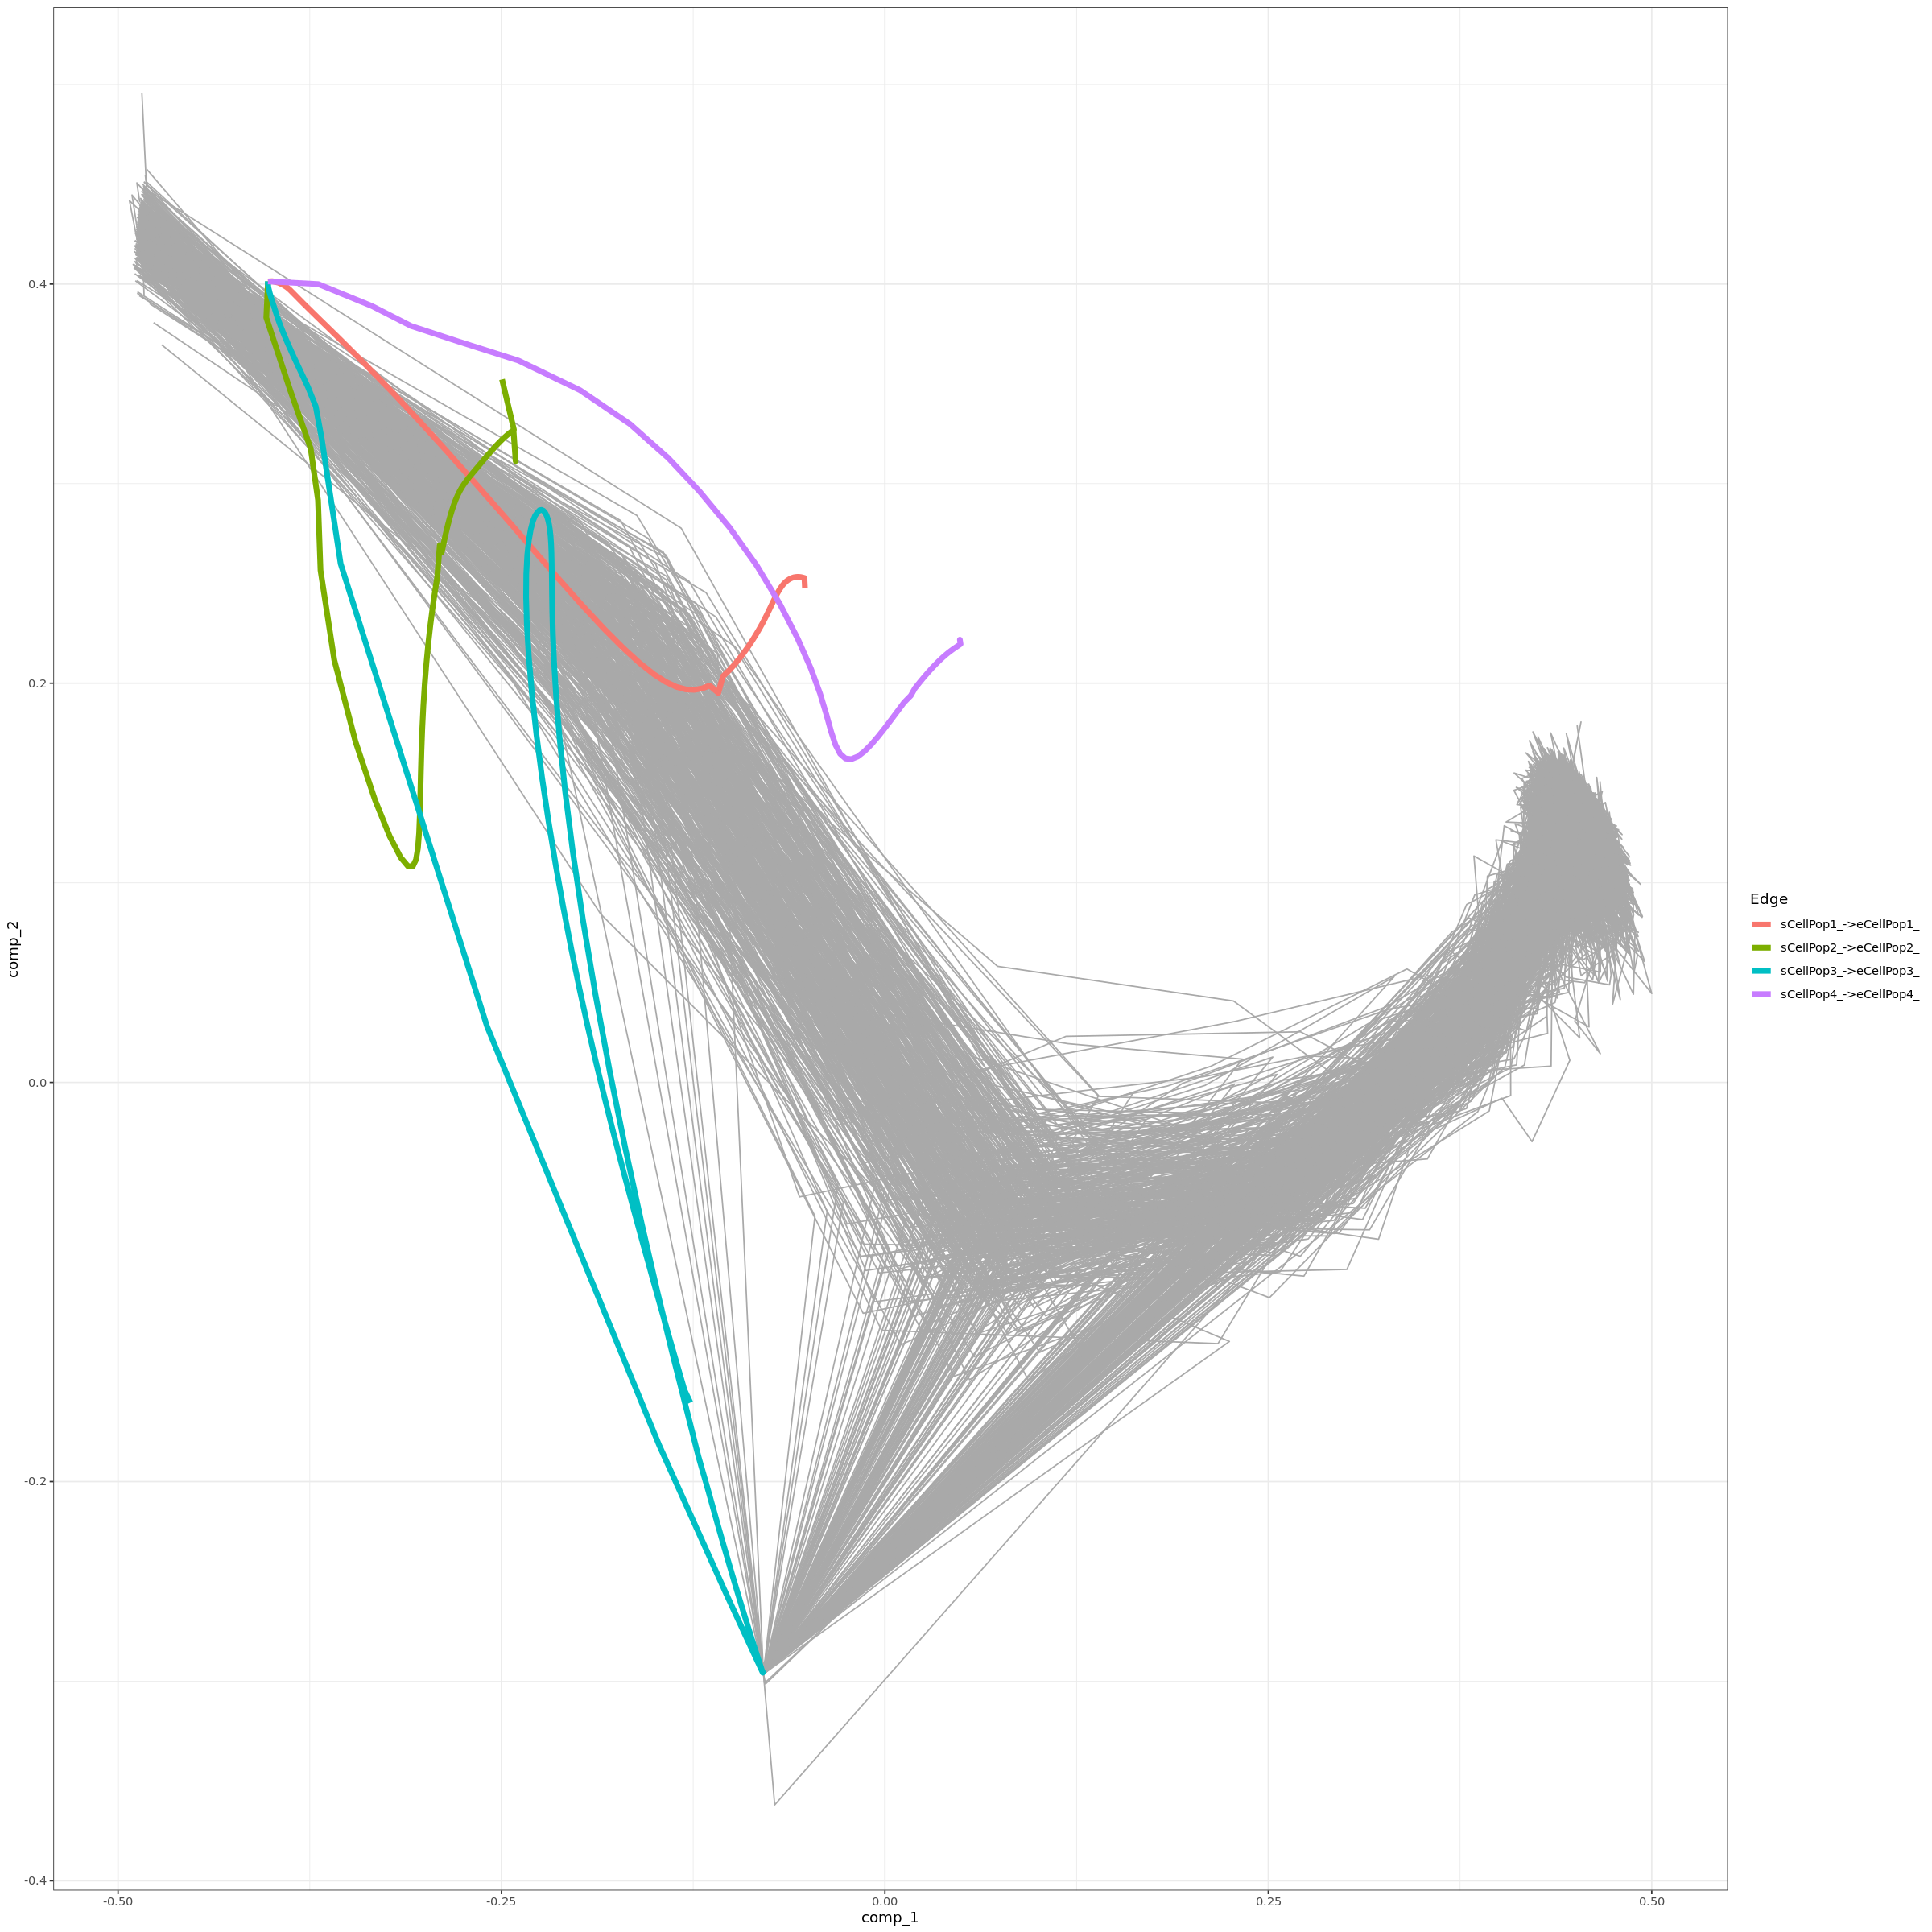

In [385]:
plot_gold_simulations(model)

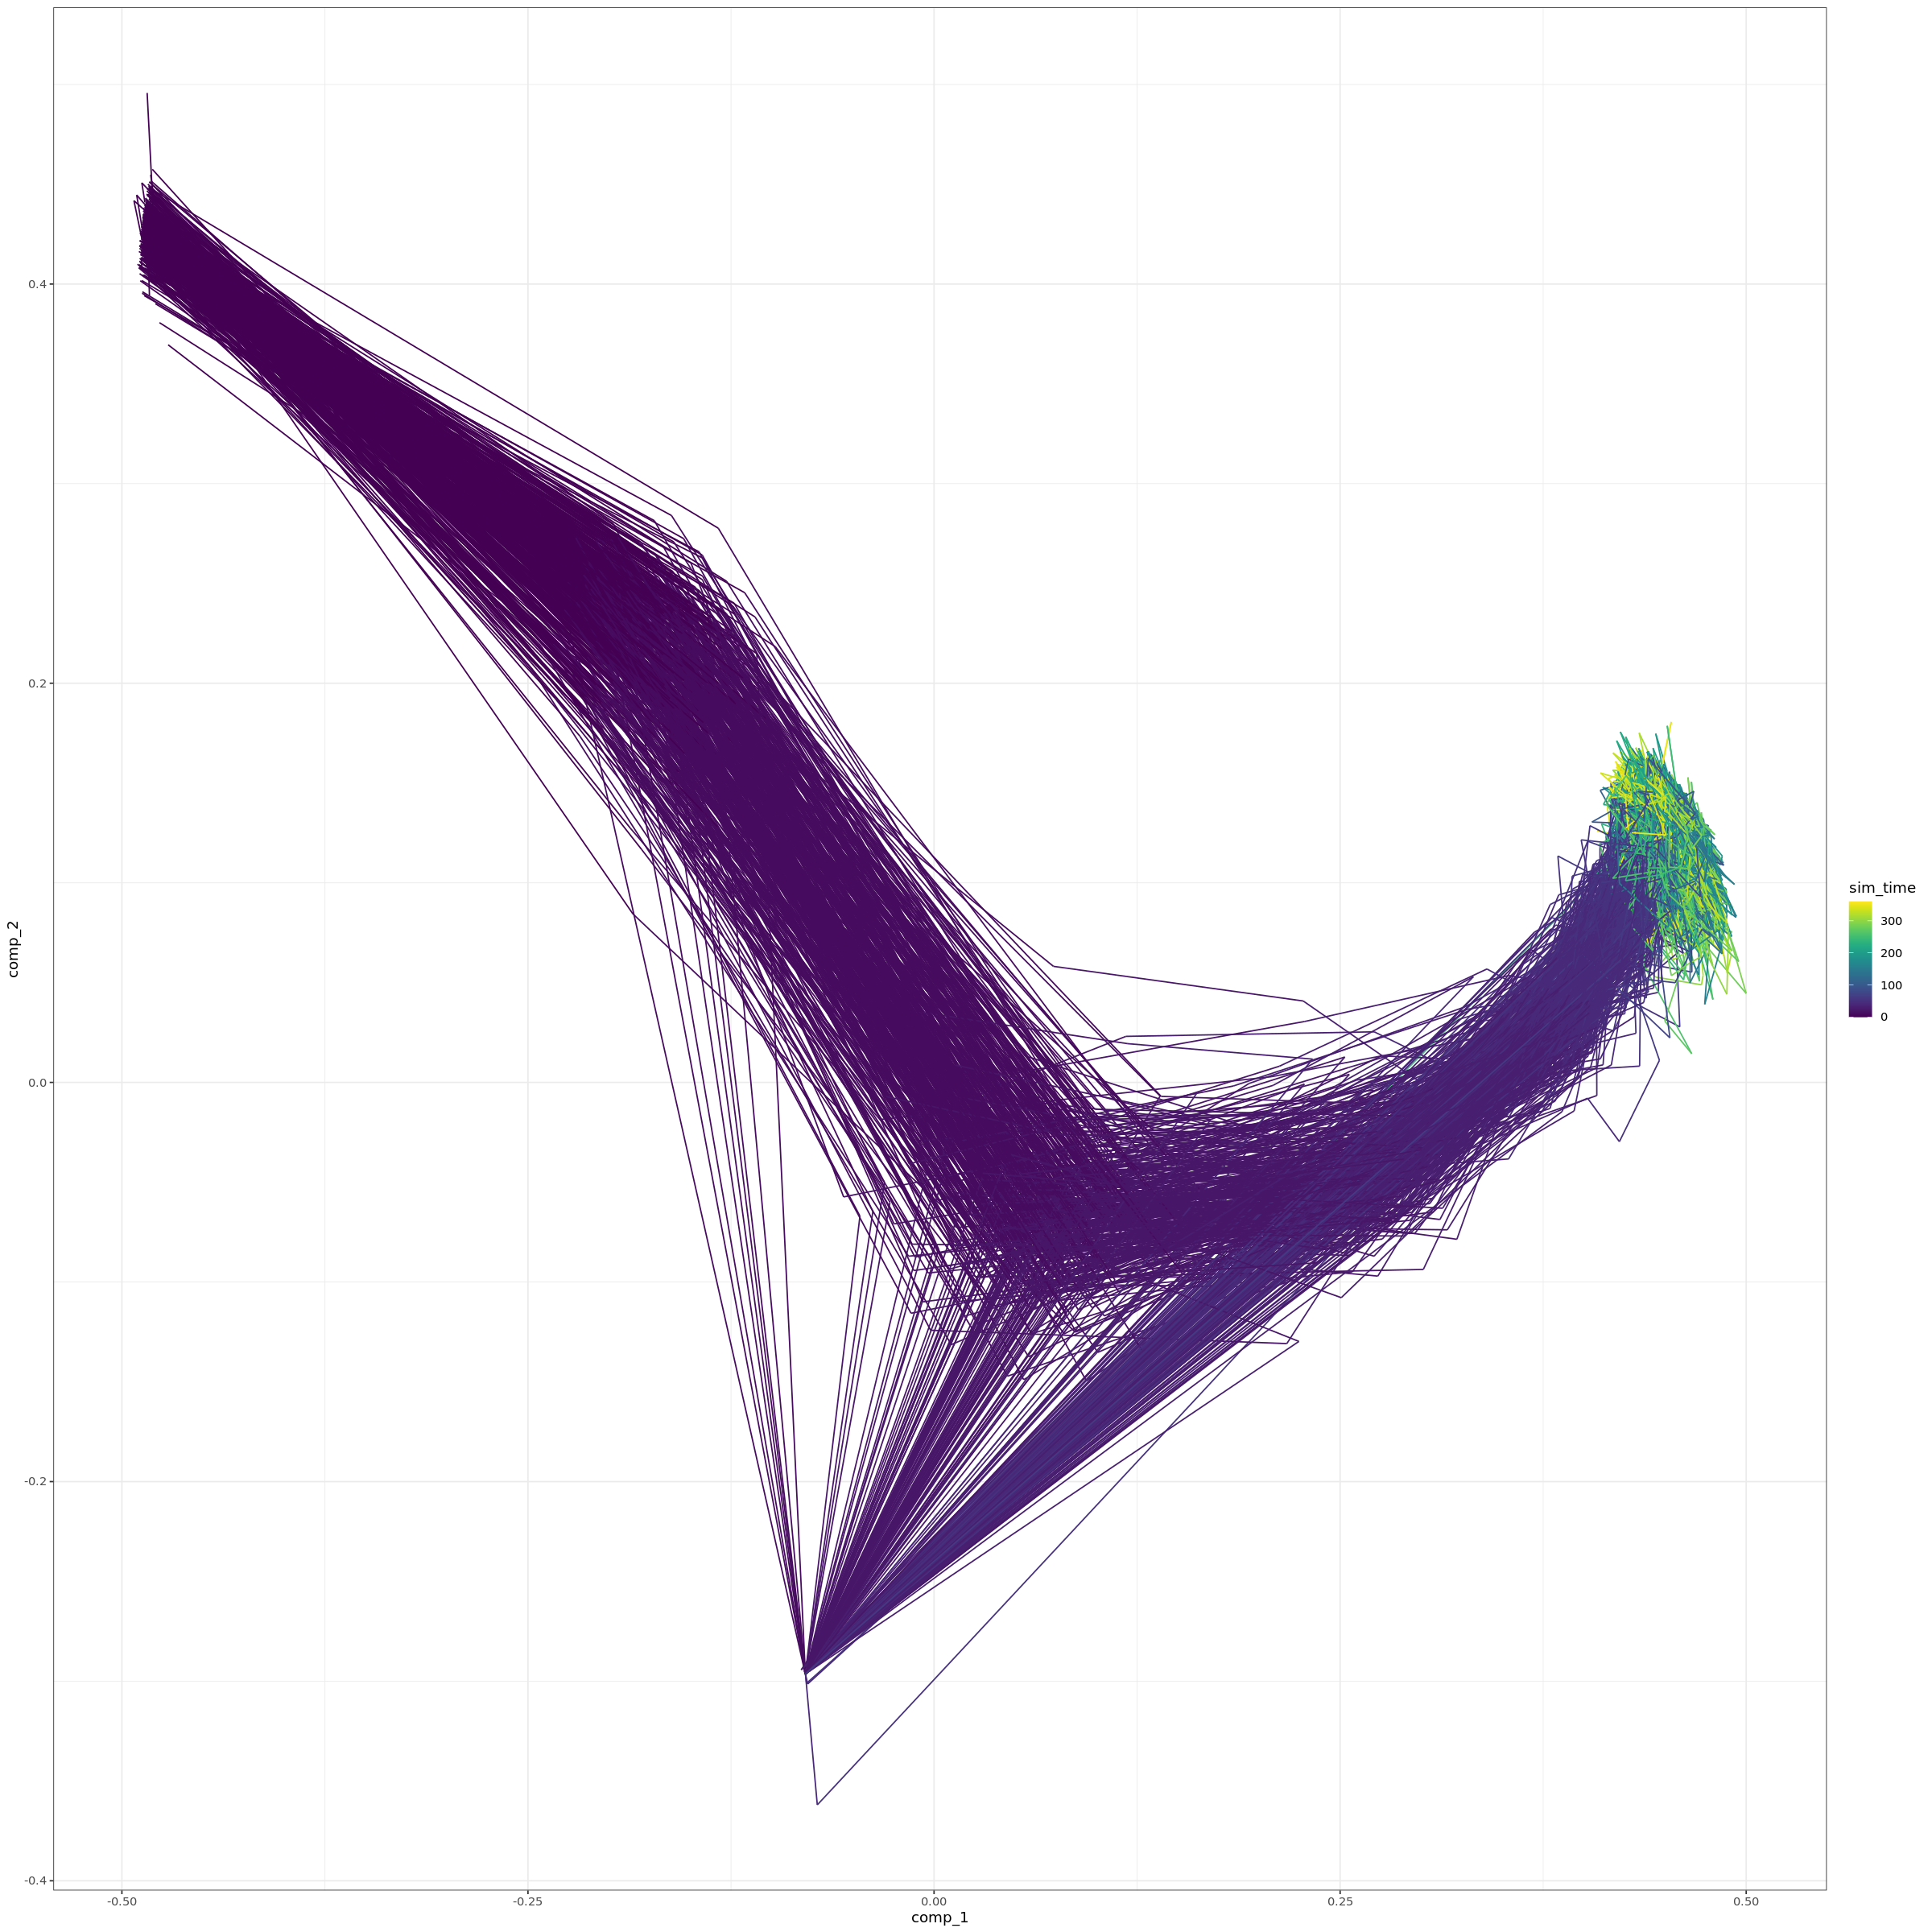

In [386]:
plot_simulations(model)

### Single Cell Experiment of Cell Population

In [387]:
sce = as_sce(model)
colData(sce)$cell_pop = gsub('s|*_', '', model$experiment$cell_info$from)

In [388]:
clust.sce = quickCluster(sce) 
sce = computeSumFactors(sce, cluster=clust.sce)
sce = logNormCounts(sce)

dec = modelGeneVar(sce)
chosen = getTopHVGs(dec, prop=0.1)

sce = runPCA(sce, subset_row=chosen) 
sce = runUMAP(sce, dimred="PCA")

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”


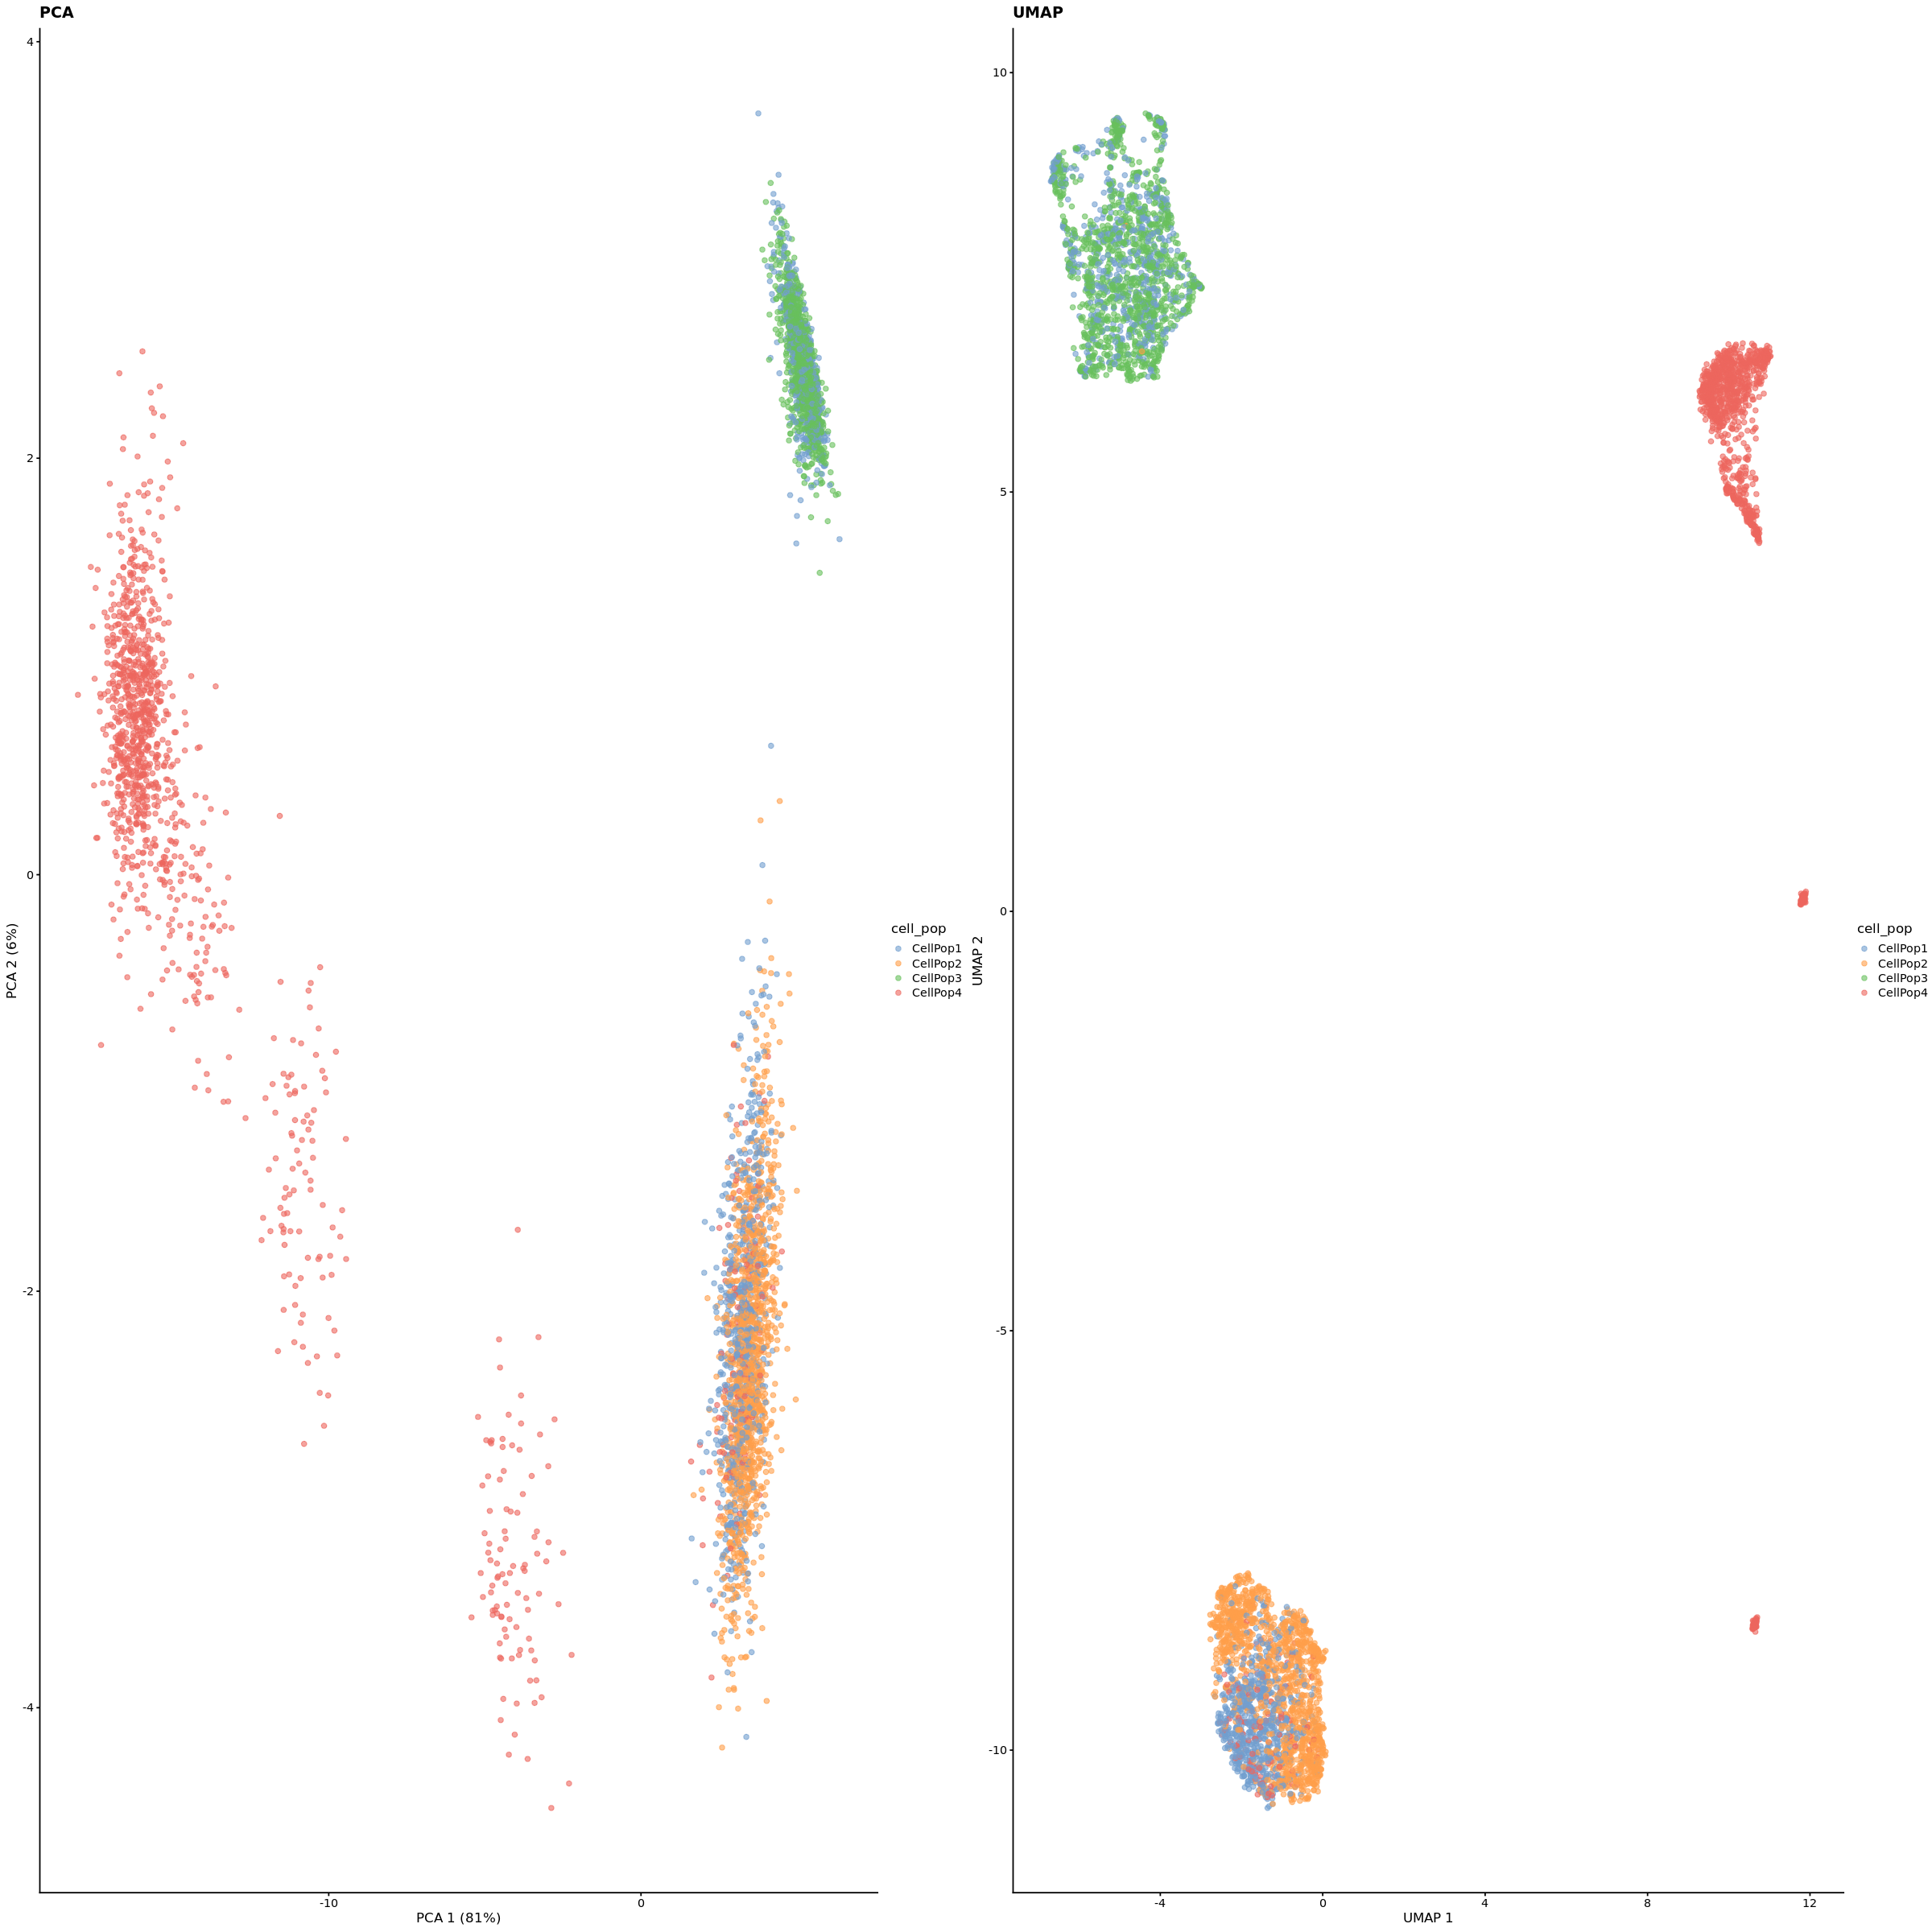

In [389]:
gridExtra::grid.arrange(
    plotPCA(sce, colour_by='cell_pop') + ggtitle("PCA"),
    plotUMAP(sce, colour_by='cell_pop') + ggtitle("UMAP"),
    ncol=2
)